### Oil type by origin
Goal: Determine oil type weighting in tank traffic by destination and vessel type


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yaml

In [2]:
# User inputs
file_dir  = '/Users/rmueller/Data/MIDOSS/DeptOfEcology/'
file_name = 'MuellerTrans4-30-20.xlsx'

In [3]:
# Import columns are: (G) Deliverer, (H) Receiver, (O) Region, (P) Product, 
#                     (Q) Quantity in Gallons, (R) Transfer Type (Fueling, Cargo, or Other)', 
#                     (w) DelivererTypeDescription, (x) ReceiverTypeDescription 
df = pd.read_excel(f'{file_dir}{file_name}',sheet_name='Vessel Oil Transfer', 
                   usecols="G,H,P,Q,R,W,X")

# create a dataframe for tug traffic from westridge
tugs_from_westridge = pd.DataFrame(columns = df.columns)

### create a list of all terminals included in the dataset, together with Region 
(so we can isolate Salish Sea) 

In [4]:
# The following list includes facilities used in Casey's origin/destination analysis 
# with names matching the Dept. of Ecology (DOE) database.  
# For example, the shapefile "Maxum Petroleum - Harbor Island Terminal" is labeled as 'Maxum (Rainer Petroleum)'
# in the DOE database.  I use the Ecology language here and will need to translate to Shapefile speak 
facility_names = [ 'BP Cherry Point Refinery', 'Shell Puget Sound Refinery', 'Shell Oil LP Seattle Distribution Terminal',
                   'Maxum (Rainer Petroleum)', 'Tidewater Snake River Terminal','Nustar Energy Tacoma', 
                   'SeaPort Sound Terminal', 'Tesoro Vancouver Terminal','Phillips 66 Ferndale Refinery', 
                   'Phillips 66 Tacoma Terminal', 'Andeavor Anacortes Refinery (formerly Tesoro)',
                   'Tesoro Port Angeles Terminal','U.S. Oil & Refining','US Oil Tacoma ','Naval Air Station Whidbey Island (NASWI)',
                   'NAVSUP Manchester', 'Alon Asphalt Company (Paramount Petroleum)', 'Kinder Morgan Liquids Terminal - Harbor Island',
                   'Nustar Energy Tacoma', 'Tesoro Pasco Terminal', 'REG Grays Harbor, LLC', 'Tidewater Vancouver Terminal',
                   'TLP','TLP Management Services LLC (TMS)']

## Create dictionary for fuel information

In [5]:
[nrows,ncols] = df.shape

# Create a destination dictionary
destination = {}
destination['names'] = facility_names.copy() 
destination['names'].remove('US Oil Tacoma ') # keeping 'U.S. Oil & Refining'
destination['names'].remove('TLP')           # 'TLP Management Services LLC (TMS)'

# Create an origin dictionary
origin = {}
origin['names'] = facility_names.copy()  #####  REMOVE TLP AND US OIL TACOMA FROM THIS LIST  ####
origin['names'].remove('US Oil Tacoma ') # keeping 'U.S. Oil & Refining'
origin['names'].remove('TLP')           # 'TLP Management Services LLC (TMS)'

# define vessel and fuel types to include in .yaml file
vessel_types = ['atb', 'tug', 'tanker']
fuel_type    = ['akns', 'bunker', 'dilbit', 'jet', 'diesel', 'gas', 'other']
data_type    = ['total_gallons', 'percent_of_total', 'number_of_transfers']

for rows in range(nrows):
  
    # Create dictionary structure for destination
    if df.Receiver[rows] in facility_names:
        
        # create dictionary labels for each location (first two are special cases to catch bad data entry)       
        if (df.Receiver[rows] == 'TLP' or 
             df.Receiver[rows] == 'TLP Management Services LLC (TMS)'
           ):
            label = 'TLP Management Services LLC (TMS)'
        elif df.Receiver[rows] == 'U.S. Oil & Refining' or 'US Oil' in df.Receiver[rows]:
            label = 'U.S. Oil & Refining'
        else: # for the entries that are well-behaved!
            label = f'{df.Receiver[rows]}'
        
        # create dictionaries for each location     
        destination[f'{label}'] = {}

        for vessel in vessel_types:
            destination[f'{label}'][f'{vessel}'] = {}
            for fuel in fuel_type:
                destination[f'{label}'][f'{vessel}'][f'{fuel}'] = {}
                for data in data_type:
                    destination[f'{label}'][f'{vessel}'][f'{fuel}'][f'{data}'] = 0

 # Create dictionary structure for origin
    if df.Deliverer[rows] in facility_names:
        
        # create dictionary labels for each location (first two are special cases to catch bad data entry)       
        if (df.Deliverer[rows] == 'TLP' or 
            df.Deliverer[rows] == 'TLP Management Services LLC (TMS)'
           ):
            label = 'TLP Management Services LLC (TMS)'      
        elif (df.Deliverer[rows] == 'U.S. Oil & Refining' or 
              'US Oil' in df.Deliverer[rows]
             ):
            label = 'U.S. Oil & Refining'
        else: # for the entries that are well-behaved!
            label = f'{df.Deliverer[rows]}'
        
        # create dictionaries for each location     
        origin[f'{label}'] = {}
        
        for vessel in vessel_types:
            origin[f'{label}'][f'{vessel}'] = {}
            for fuel in fuel_type:
                origin[f'{label}'][f'{vessel}'][f'{fuel}'] = {}
                for data in data_type:
                    origin[f'{label}'][f'{vessel}'][f'{fuel}'][f'{data}'] = 0


In [6]:
destination['names'] 

['BP Cherry Point Refinery',
 'Shell Puget Sound Refinery',
 'Shell Oil LP Seattle Distribution Terminal',
 'Maxum (Rainer Petroleum)',
 'Tidewater Snake River Terminal',
 'Nustar Energy Tacoma',
 'SeaPort Sound Terminal',
 'Tesoro Vancouver Terminal',
 'Phillips 66 Ferndale Refinery',
 'Phillips 66 Tacoma Terminal',
 'Andeavor Anacortes Refinery (formerly Tesoro)',
 'Tesoro Port Angeles Terminal',
 'U.S. Oil & Refining',
 'Naval Air Station Whidbey Island (NASWI)',
 'NAVSUP Manchester',
 'Alon Asphalt Company (Paramount Petroleum)',
 'Kinder Morgan Liquids Terminal - Harbor Island',
 'Nustar Energy Tacoma',
 'Tesoro Pasco Terminal',
 'REG Grays Harbor, LLC',
 'Tidewater Vancouver Terminal',
 'TLP Management Services LLC (TMS)']

## Loop through data again and catalog fuel information

In [7]:
## Loop through data again and catalog fuel information

####  NOTE: I USE ROWS ABOVE AND ROW HERE.  THAT'S CRAZY MAKING.  I PLAN TO FIX. 
for row in range(nrows):
    
    # Catalogue fuel imports (destination traffic)
    if (df.Receiver[row] in facility_names and 
        df.TransferType[row] == 'Cargo'
       ):        
        if (df.Receiver[row] == 'TLP' or 
            df.Receiver[row] == 'TLP Management Services LLC (TMS)'
           ):            
            label = 'TLP Management Services LLC (TMS)'            
        elif (df.Receiver[row] == 'U.S. Oil & Refining' or 
              'US Oil' in df.Receiver[row]
             ):            
            label = 'U.S. Oil & Refining'            
        else: # for the entries that are well-behaved!
            label = f'{df.Receiver[row]}'

        # Now ensure that the deliverer is a tank, barge or atb
        if df.DelivererTypeDescription[row] == 'TANK SHIP':

            # Determine fuel-type in transfer 
            if 'CRUDE' in df.Product[row]:
                destination[f'{label}']['tanker']['akns']['total_gallons'] += df.TransferQtyInGallon[row].item()
                destination[f'{label}']['tanker']['akns']['number_of_transfers'] += 1
                
            elif df.Product[row] == 'BUNKER OIL/HFO':
                destination[f'{label}']['tanker']['bunker']['total_gallons'] += df.TransferQtyInGallon[row].item()
                destination[f'{label}']['tanker']['bunker']['number_of_transfers'] += 1

            elif df.Product[row] == 'GASOLINE':
                destination[f'{label}']['tanker']['gas']['total_gallons'] += df.TransferQtyInGallon[row].item()
                destination[f'{label}']['tanker']['gas']['number_of_transfers'] += 1

            elif df.Product[row] == 'JET FUEL/KEROSENE':
                destination[f'{label}']['tanker']['jet']['total_gallons'] += df.TransferQtyInGallon[row].item()
                destination[f'{label}']['tanker']['jet']['number_of_transfers'] += 1

            elif 'DIESEL' in df.Product[row]: 
                # inclusive if BIODIESEL, DIESEL/MARINE GAS OIl, and DIESEL LOW SULPHUR (ULSD)
                destination[f'{label}']['tanker']['diesel']['total_gallons'] += df.TransferQtyInGallon[row].item()
                destination[f'{label}']['tanker']['diesel']['number_of_transfers'] += 1

            else:
                destination[f'{label}']['tanker']['other']['total_gallons'] += df.TransferQtyInGallon[row].item()
                destination[f'{label}']['tanker']['other']['number_of_transfers'] += 1

        # ATBs
        elif ( df.DelivererTypeDescription[row] == 'TANK BARGE' or 
               df.DelivererTypeDescription[row] == 'TUGBOAT' and 
              'ATB' in df.Deliverer[row] or 
              'ITB' in df.Deliverer[row] ):
            
            
             # Determine fuel-type in transfer 
            if 'CRUDE' in df.Product[row]:
                destination[f'{label}']['atb']['akns']['total_gallons'] += df.TransferQtyInGallon[row].item()
                destination[f'{label}']['atb']['akns']['number_of_transfers'] += 1
                
            elif df.Product[row] == 'BUNKER OIL/HFO':
                destination[f'{label}']['atb']['bunker']['total_gallons'] += df.TransferQtyInGallon[row].item()
                destination[f'{label}']['atb']['bunker']['number_of_transfers'] += 1

            elif df.Product[row] == 'GASOLINE':
                destination[f'{label}']['atb']['gas']['total_gallons'] += df.TransferQtyInGallon[row].item()
                destination[f'{label}']['atb']['gas']['number_of_transfers'] += 1

            elif df.Product[row] == 'JET FUEL/KEROSENE':
                destination[f'{label}']['atb']['jet']['total_gallons'] += df.TransferQtyInGallon[row].item()
                destination[f'{label}']['atb']['jet']['number_of_transfers'] += 1

            elif 'DIESEL' in df.Product[row]: 
                # inclusive if BIODIESEL, DIESEL/MARINE GAS OIl, and DIESEL LOW SULPHUR (ULSD)
                destination[f'{label}']['tug']['diesel']['total_gallons'] += df.TransferQtyInGallon[row].item()
                destination[f'{label}']['tug']['diesel']['number_of_transfers'] += 1

            else:
                destination[f'{label}']['tug']['other']['total_gallons'] += df.TransferQtyInGallon[row].item()
                destination[f'{label}']['tug']['other']['number_of_transfers'] += 1
        
        # Tank-barges
        elif ( df.DelivererTypeDescription[row] == 'TANK BARGE' or 
               df.DelivererTypeDescription[row] == 'TUGBOAT' and 
              'ATB' not in df.Deliverer[row] and 
              'ITB' not in df.Deliverer[row] ):
            
            # Determine fuel-type in transfer 
            if 'CRUDE' in df.Product[row]:
                destination[f'{label}']['tug']['akns']['total_gallons'] += df.TransferQtyInGallon[row].item()
                destination[f'{label}']['tug']['akns']['number_of_transfers'] += 1
                
            elif df.Product[row] == 'BUNKER OIL/HFO':
                destination[f'{label}']['tug']['bunker']['total_gallons'] += df.TransferQtyInGallon[row].item()
                destination[f'{label}']['tug']['bunker']['number_of_transfers'] += 1

            elif df.Product[row] == 'GASOLINE':
                destination[f'{label}']['tug']['gas']['total_gallons'] += df.TransferQtyInGallon[row].item()
                destination[f'{label}']['tug']['gas']['number_of_transfers'] += 1

            elif df.Product[row] == 'JET FUEL/KEROSENE':
                destination[f'{label}']['tug']['jet']['total_gallons'] += df.TransferQtyInGallon[row].item()
                destination[f'{label}']['tug']['jet']['number_of_transfers'] += 1

            elif 'DIESEL' in df.Product[row]: 
                # inclusive if BIODIESEL, DIESEL/MARINE GAS OIl, and DIESEL LOW SULPHUR (ULSD)
                destination[f'{label}']['tug']['diesel']['total_gallons'] += df.TransferQtyInGallon[row].item()
                destination[f'{label}']['tug']['diesel']['number_of_transfers'] += 1

            else:
                destination[f'{label}']['tug']['other']['total_gallons'] += df.TransferQtyInGallon[row].item()
                destination[f'{label}']['tug']['other']['number_of_transfers'] += 1
            
            # find tugs transporting fuel from Westridge
            if f'{label}'=='U.S. Oil & Refining':
                tugs_from_westridge = tugs_from_westridge.append( df.iloc[row] )
                
        else:
            print(f'[{row}]: Cargo transfer of {df.TransferQtyInGallon[row].item():4.2e} gallons of {df.Product[row]} from {df.DelivererTypeDescription[row]} to {df.Receiver[row]} ')
            
   # Catalogue fuel exports (origin traffic)
    if (df.Deliverer[row] in facility_names and 
        df.TransferType[row] == 'Cargo'
       ):
        
        if (df.Deliverer[row] == 'TLP' or 
            df.Deliverer[row] == 'TLP Management Services LLC (TMS)'
           ):
            label = 'TLP Management Services LLC (TMS)'
        elif (df.Deliverer[row] == 'U.S. Oil & Refining' or 
              'US Oil' in df.Deliverer[row]
             ):
            label = 'U.S. Oil & Refining'
        else: # for the entries that are well-behaved!
            label = f'{df.Deliverer[row]}'

        # Now ensure that the deliverer is a tank, barge or atb
        if df.ReceiverTypeDescription[row] == 'TANK SHIP':

            # Determine fuel-type in transfer 
            if 'CRUDE' in df.Product[row]:
                origin[f'{label}']['tanker']['akns']['total_gallons'] += df.TransferQtyInGallon[row].item()
                origin[f'{label}']['tanker']['akns']['number_of_transfers'] += 1
                
            elif df.Product[row] == 'BUNKER OIL/HFO':
                origin[f'{label}']['tanker']['bunker']['total_gallons'] += df.TransferQtyInGallon[row].item()
                origin[f'{label}']['tanker']['bunker']['number_of_transfers'] += 1

            elif df.Product[row] == 'GASOLINE':
                origin[f'{label}']['tanker']['gas']['total_gallons'] += df.TransferQtyInGallon[row].item()
                origin[f'{label}']['tanker']['gas']['number_of_transfers'] += 1

            elif df.Product[row] == 'JET FUEL/KEROSENE':
                origin[f'{label}']['tanker']['jet']['total_gallons'] += df.TransferQtyInGallon[row].item()
                origin[f'{label}']['tanker']['jet']['number_of_transfers'] += 1

            elif 'DIESEL' in df.Product[row]: 
                # inclusive if BIODIESEL, DIESEL/MARINE GAS OIl, and DIESEL LOW SULPHUR (ULSD)
                origin[f'{label}']['tanker']['diesel']['total_gallons'] += df.TransferQtyInGallon[row].item()
                origin[f'{label}']['tanker']['diesel']['number_of_transfers'] += 1

            else:
                origin[f'{label}']['tanker']['other']['total_gallons'] += df.TransferQtyInGallon[row].item()
                origin[f'{label}']['tanker']['other']['number_of_transfers'] += 1
        
        # ATBs
        elif ( df.ReceiverTypeDescription[row] == 'TANK BARGE' and 
              'ATB' in df.Receiver[row] or 
              'ITB' in df.Receiver[row] ):
             
             # Determine fuel-type in transfer 
            if 'CRUDE' in df.Product[row]:
                origin[f'{label}']['atb']['akns']['total_gallons'] += df.TransferQtyInGallon[row].item()
                origin[f'{label}']['atb']['akns']['number_of_transfers'] += 1
                
            elif df.Product[row] == 'BUNKER OIL/HFO':
                origin[f'{label}']['atb']['bunker']['total_gallons'] += df.TransferQtyInGallon[row].item()
                origin[f'{label}']['atb']['bunker']['number_of_transfers'] += 1

            elif df.Product[row] == 'GASOLINE':
                origin[f'{label}']['atb']['gas']['total_gallons'] += df.TransferQtyInGallon[row].item()
                origin[f'{label}']['atb']['gas']['number_of_transfers'] += 1

            elif df.Product[row] == 'JET FUEL/KEROSENE':
                origin[f'{label}']['atb']['jet']['total_gallons'] += df.TransferQtyInGallon[row].item()
                origin[f'{label}']['atb']['jet']['number_of_transfers'] += 1

            elif 'DIESEL' in df.Product[row]: 
                # inclusive if BIODIESEL, DIESEL/MARINE GAS OIl, and DIESEL LOW SULPHUR (ULSD)
                origin[f'{label}']['tug']['diesel']['total_gallons'] += df.TransferQtyInGallon[row].item()
                origin[f'{label}']['tug']['diesel']['number_of_transfers'] += 1

            else:
                origin[f'{label}']['tug']['other']['total_gallons'] += df.TransferQtyInGallon[row].item()
                origin[f'{label}']['tug']['other']['number_of_transfers'] += 1
        
        # Tank-barges
        elif ( df.ReceiverTypeDescription[row] == 'TANK BARGE' or 
               df.ReceiverTypeDescription[row] == 'TUGBOAT' and 
              'ATB' not in df.Receiver[row] and 
              'ITB' not in df.Receiver[row] ):
            
            # Determine fuel-type in transfer 
            if 'CRUDE' in df.Product[row]:
                origin[f'{label}']['tug']['akns']['total_gallons'] += df.TransferQtyInGallon[row].item()
                origin[f'{label}']['tug']['akns']['number_of_transfers'] += 1
                
            elif df.Product[row] == 'BUNKER OIL/HFO':
                origin[f'{label}']['tug']['bunker']['total_gallons'] += df.TransferQtyInGallon[row].item()
                origin[f'{label}']['tug']['bunker']['number_of_transfers'] += 1

            elif df.Product[row] == 'GASOLINE':
                origin[f'{label}']['tug']['gas']['total_gallons'] += df.TransferQtyInGallon[row].item()
                origin[f'{label}']['tug']['gas']['number_of_transfers'] += 1

            elif df.Product[row] == 'JET FUEL/KEROSENE':
                origin[f'{label}']['tug']['jet']['total_gallons'] += df.TransferQtyInGallon[row].item()
                origin[f'{label}']['tug']['jet']['number_of_transfers'] += 1

            elif 'DIESEL' in df.Product[row]: 
                # inclusive if BIODIESEL, DIESEL/MARINE GAS OIl, and DIESEL LOW SULPHUR (ULSD)
                origin[f'{label}']['tug']['diesel']['total_gallons'] += df.TransferQtyInGallon[row].item()
                origin[f'{label}']['tug']['diesel']['number_of_transfers'] += 1

            else:
                origin[f'{label}']['tug']['other']['total_gallons'] += df.TransferQtyInGallon[row].item()
                origin[f'{label}']['tug']['other']['number_of_transfers'] += 1
            
        else:
            print(f'[{row}]: Cargo transfer of {df.TransferQtyInGallon[row].item():4.2e} gallons of {df.Product[row]} from {df.Deliverer[row]} to {df.ReceiverTypeDescription[row]} ')

[327]: Cargo transfer of 5.67e+05 gallons of JET FUEL/KEROSENE from Un-regulated Vessel to Naval Air Station Whidbey Island (NASWI) 
[658]: Cargo transfer of 1.05e+06 gallons of GASOLINE from BULK CARRIER to Tesoro Pasco Terminal 
[868]: Cargo transfer of 1.23e+07 gallons of DIESEL/MARINE GAS OIL from BP Cherry Point Refinery to Un-regulated Vessel 
[931]: Cargo transfer of 7.98e+05 gallons of GASOLINE from Un-regulated Vessel to Tesoro Pasco Terminal 
[932]: Cargo transfer of 1.01e+06 gallons of GASOLINE from Un-regulated Vessel to Tidewater Snake River Terminal 
[933]: Cargo transfer of 1.26e+06 gallons of ETHANOL from Tidewater Snake River Terminal to Un-regulated Vessel 
[965]: Cargo transfer of 5.67e+05 gallons of JET FUEL/KEROSENE from Un-regulated Vessel to Naval Air Station Whidbey Island (NASWI) 
[1125]: Cargo transfer of 3.28e+06 gallons of Z-OTHER from Un-regulated Vessel to REG Grays Harbor, LLC 
[1349]: Cargo transfer of 5.50e+04 gallons of DIESEL/MARINE GAS OIL from Maxum

In [8]:
tugs_from_westridge

,Deliverer,Receiver,Product,TransferQtyInGallon,TransferType,DelivererTypeDescription,ReceiverTypeDescription


###  Set zero values to locations where no oil transfers are recorded for cargo

In [9]:
for facility in origin['names']:
    if facility not in origin:
        
        print(f'Origin: Adding null values to {facility}')
        
        # create dictionaries for each location     
        origin[f'{facility}'] = {}
        
        for vessel in vessel_types:
            origin[f'{facility}'][f'{vessel}'] = {}
            for fuel in fuel_type:
                origin[f'{facility}'][f'{vessel}'][f'{fuel}'] = {}
                for data in data_type:
                    origin[f'{facility}'][f'{vessel}'][f'{fuel}'][f'{data}'] = 0

for facility in destination['names']:
    if facility not in destination:
        
        print(f'Origin: Adding null values to {facility}')
        
        # create dictionaries for each location     
        destination[f'{facility}'] = {}
        
        for vessel in vessel_types:
            destination[f'{facility}'][f'{vessel}'] = {}
            for fuel in fuel_type:
                destination[f'{facility}'][f'{vessel}'][f'{fuel}'] = {}
                for data in data_type:
                    destination[f'{facility}'][f'{vessel}'][f'{fuel}'][f'{data}'] = 0




Origin: Adding null values to Shell Oil LP Seattle Distribution Terminal
Origin: Adding null values to Phillips 66 Tacoma Terminal
Origin: Adding null values to Naval Air Station Whidbey Island (NASWI)
Origin: Adding null values to REG Grays Harbor, LLC


### Loop through each location, vessel type and oil type and determine percent oil for each oil type

In [29]:
for facility in origin['names']:
    for vessel in vessel_types:
        
        # first get the total transfers over all fuel types
        total_origin = sum([ origin[f'{facility}'][f'{vessel}'][count_me_in]['total_gallons'] for count_me_in in fuel_type ])
        total_destination = sum([ destination[f'{facility}'][f'{vessel}'][count_me_in]['total_gallons'] for count_me_in in fuel_type ])
    
        for fuel in fuel_type:
            # next calculate percentages
            if total_origin != 0:
                origin[f'{facility}'][f'{vessel}'][f'{fuel}']['percent_of_total'] =  origin[f'{facility}'][f'{vessel}'][f'{fuel}']['total_gallons'] / total_origin
            if total_destination != 0:
                destination[f'{facility}'][f'{vessel}'][f'{fuel}']['percent_of_total'] = destination[f'{facility}'][f'{vessel}'][f'{fuel}']['total_gallons'] / total_destination
                

In [30]:
for facility in origin['names']:
    for vessel in vessel_types:
        sum_check_out = [origin[f'{facility}'][f'{vessel}'][fuel]['percent_of_total'] for fuel in fuel_type]
        sum_check_in = [destination[f'{facility}'][f'{vessel}'][fuel]['percent_of_total'] for fuel in fuel_type]
        if sum(sum_check_out) != 1:
            print(f'origin {vessel}, {facility}:{sum(sum_check_out)}')
        elif sum(sum_check_in) != 1:
            print(f'destination {vessel}, {facility}:{sum(sum_check_in)}')
  


origin tanker, BP Cherry Point Refinery:0.9999999999999999
origin tanker, Shell Oil LP Seattle Distribution Terminal:0
origin atb, Shell Oil LP Seattle Distribution Terminal:0
origin tug, Shell Oil LP Seattle Distribution Terminal:0
origin atb, Maxum (Rainer Petroleum):0
destination tug, Maxum (Rainer Petroleum):0
origin tanker, Tidewater Snake River Terminal:0
origin atb, Tidewater Snake River Terminal:0
origin tanker, Nustar Energy Tacoma:0
origin atb, Nustar Energy Tacoma:0
destination tug, Nustar Energy Tacoma:0
origin tanker, SeaPort Sound Terminal:0
origin atb, Tesoro Vancouver Terminal:0
destination tug, Tesoro Vancouver Terminal:0
origin tanker, Phillips 66 Tacoma Terminal:0
origin atb, Phillips 66 Tacoma Terminal:0
origin tug, Phillips 66 Tacoma Terminal:0
destination tug, Andeavor Anacortes Refinery (formerly Tesoro):0
origin tanker, Tesoro Port Angeles Terminal:0
origin atb, Tesoro Port Angeles Terminal:0
origin tanker, Naval Air Station Whidbey Island (NASWI):0
origin atb, 

In [11]:
with open(r'./WA_origin.yaml', 'w') as file:
    documents = yaml.safe_dump(origin, file)
with open(r'./WA_destination.yaml', 'w') as file:
    documents = yaml.safe_dump(destination, file)

### plot up results for WA origin and destination by vessel type

In [12]:
label = 'barge'
plot_origin = {}
facility = 'BP Cherry Point Refinery'
vessel_types = ['tanker','atb','tug']
for vessel in vessel_types:
    plot_origin[f'{vessel}'] = np.empty(7)
    fuel_index = 0
    for fuel in fuel_type:
        plot_origin[f'{vessel}'][fuel_index]=origin[f'{facility}'][f'{vessel}'][f'{fuel}']['total_gallons']
        fuel_index += 1

/Users/rmueller/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


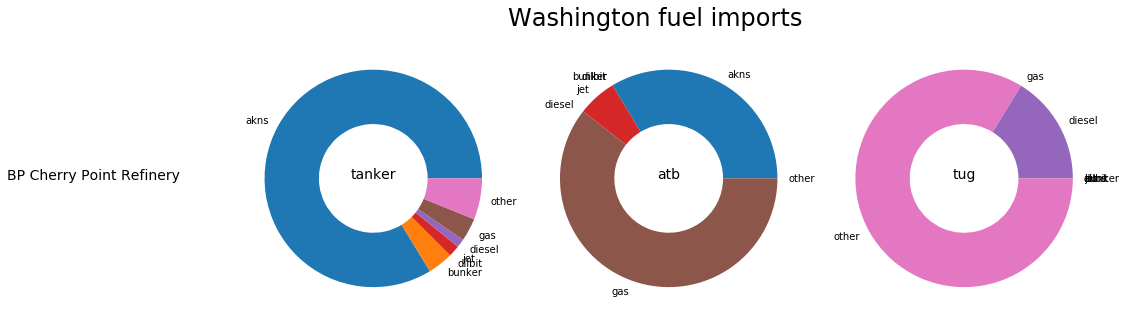

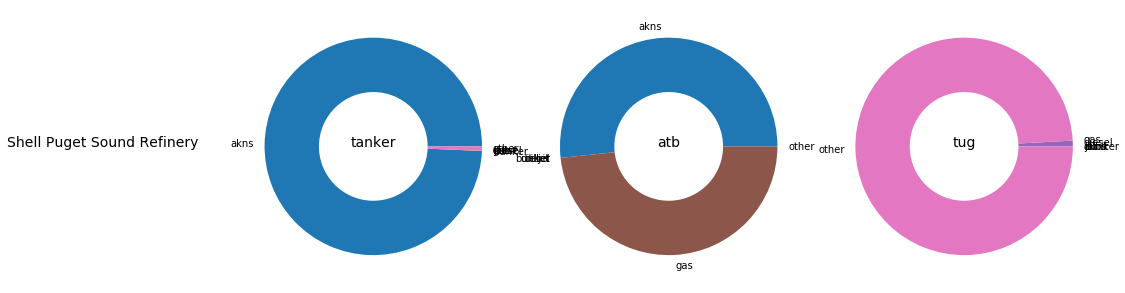

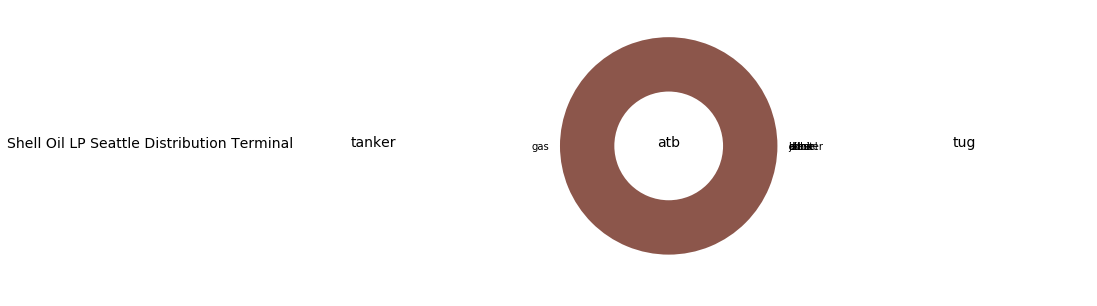

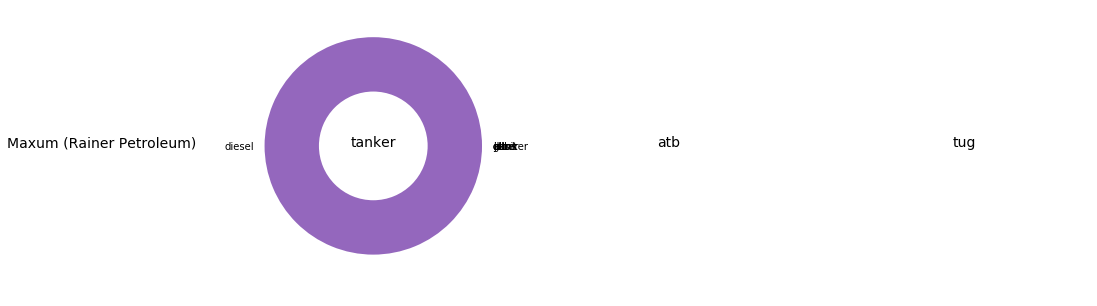

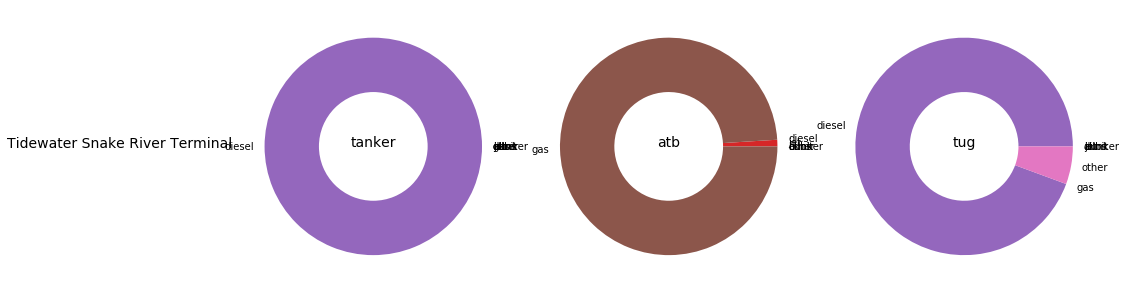

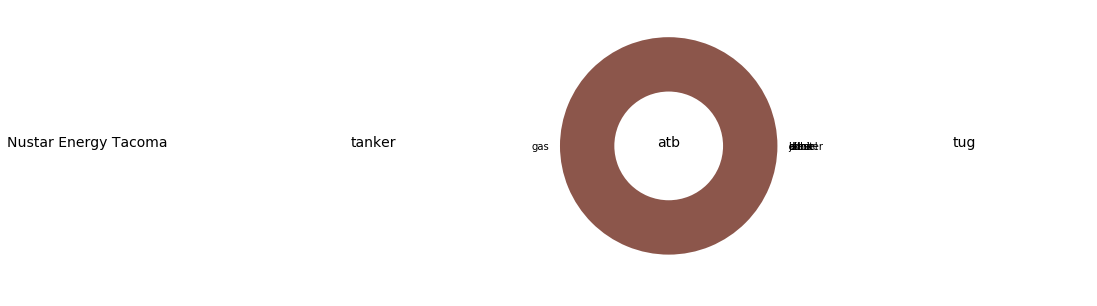

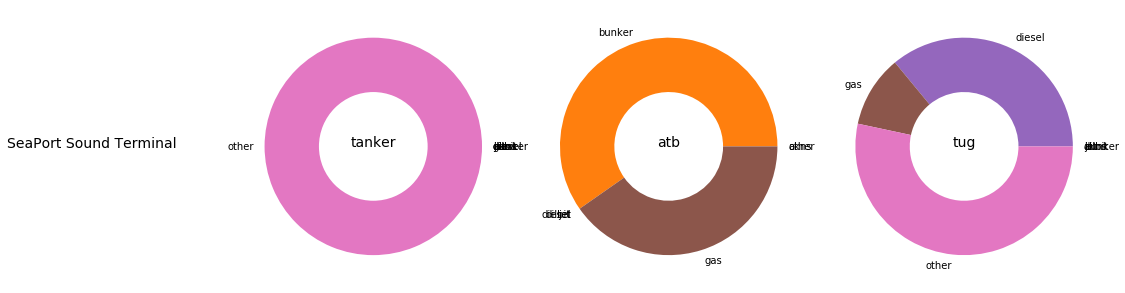

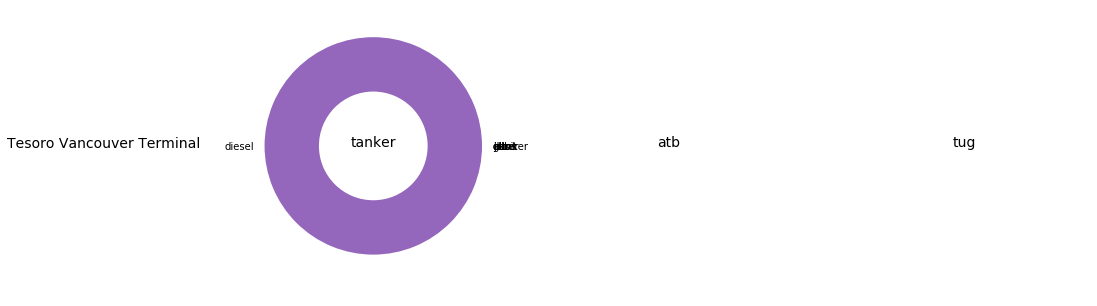

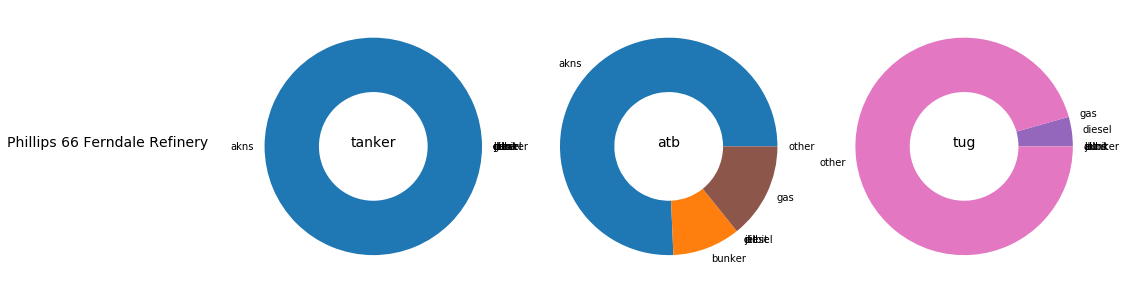

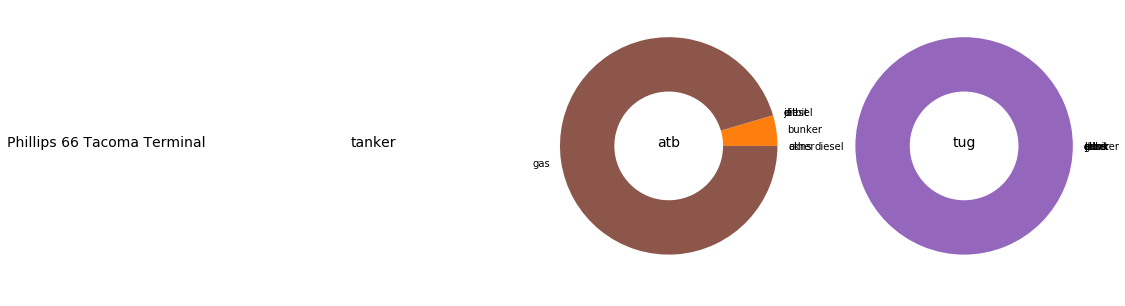

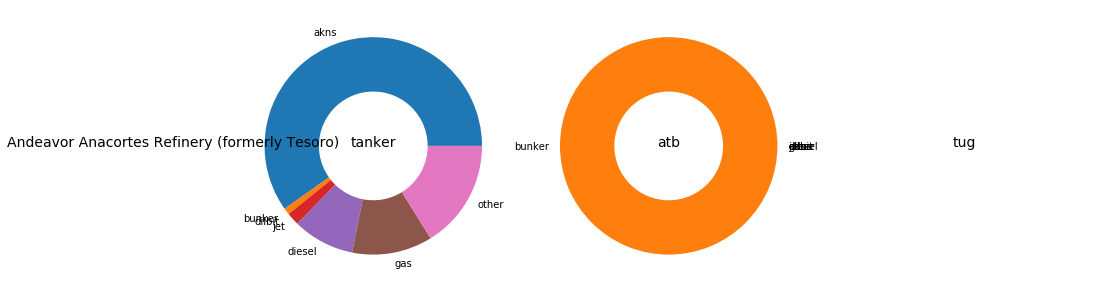

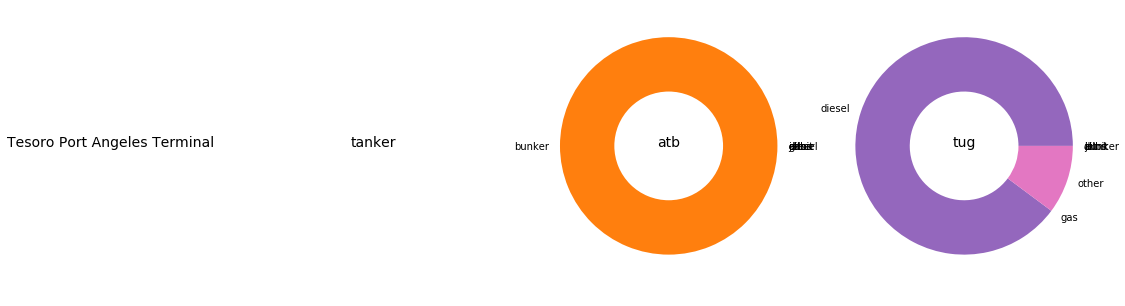

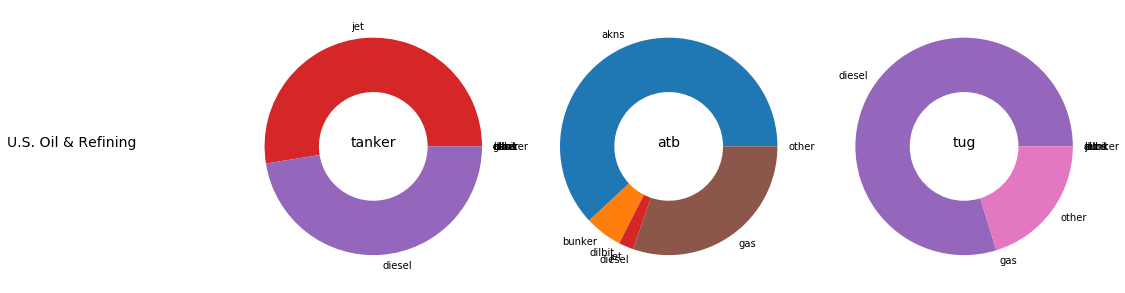

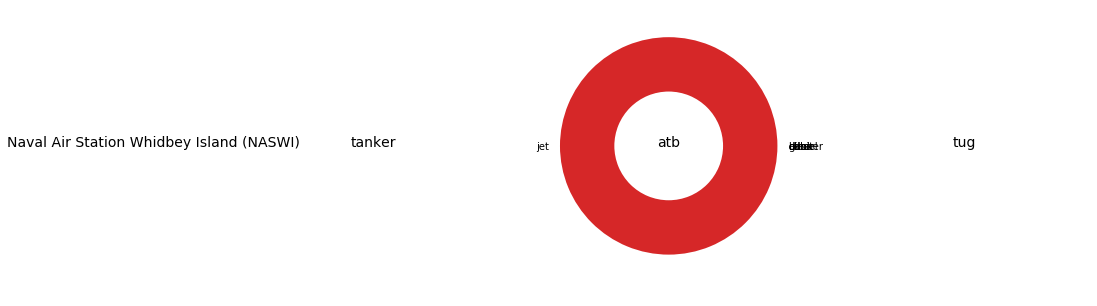

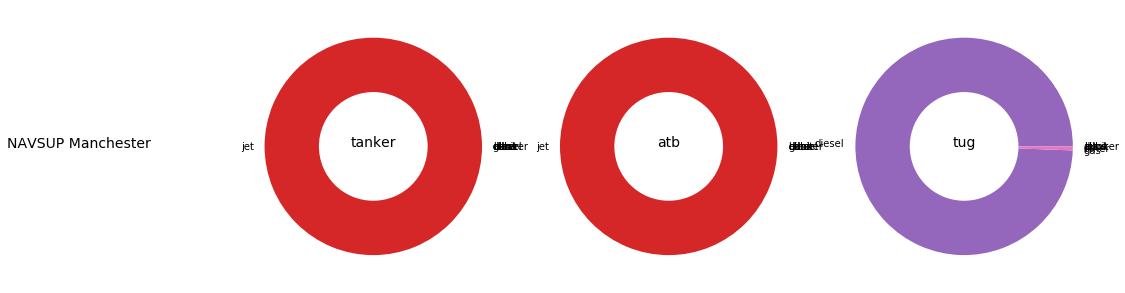

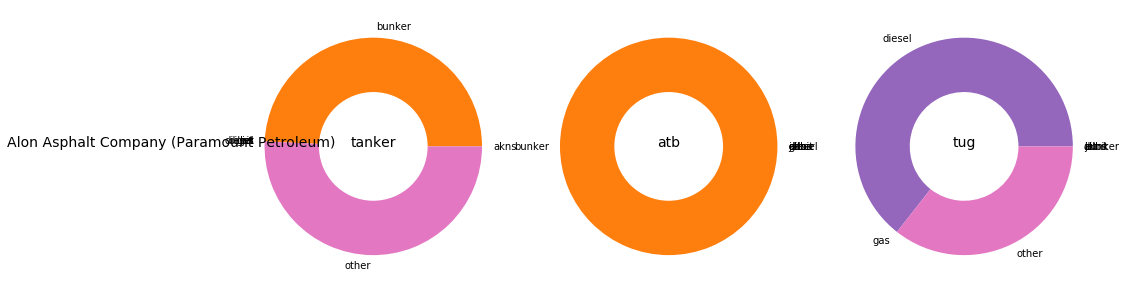

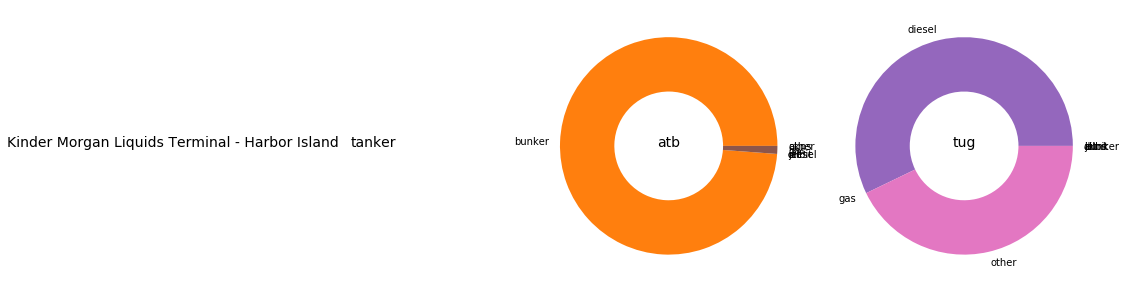

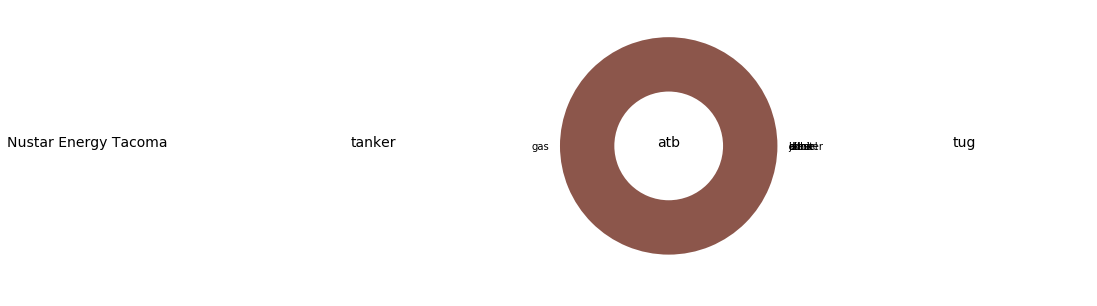

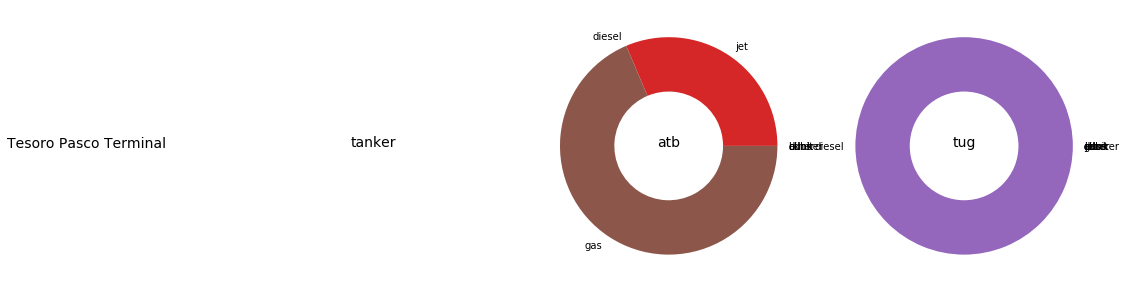

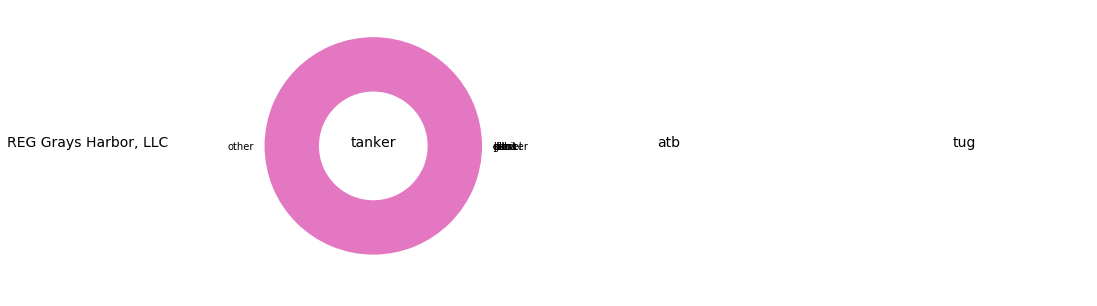

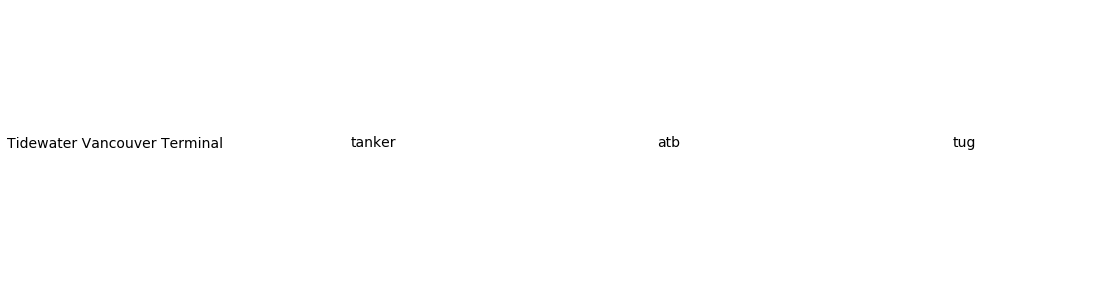

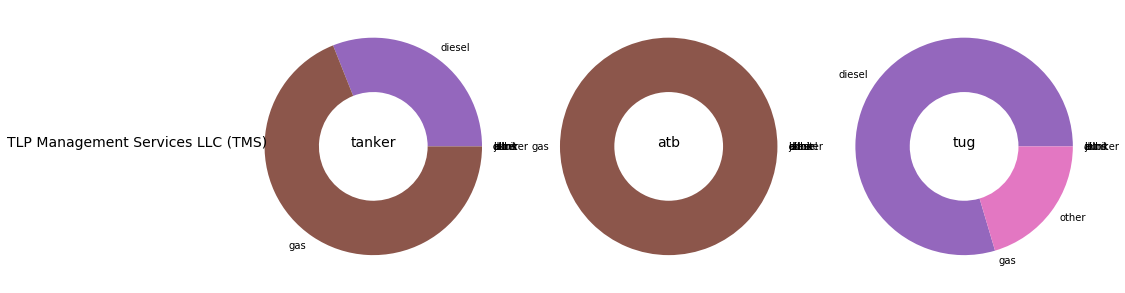

In [13]:
# axes are in a two-dimensional array, indexed by [row, col]
plot_array = np.empty(len(fuel_type))

# Create a circle for the center of the plot
#my_circle=plt.Circle( (0,0), 0.7, color='white')

for i in range(len(destination['names'])):
    fig, axes = plt.subplots(1, len(vessel_types), figsize = (15,5))
    if i == 0:
        fig.suptitle('Washington fuel imports',
                    fontsize = 24)
    facility = origin['names'][i]
    plt.text(-.1, 0.5, 
             f'{facility}', 
             ha='left',
             fontsize=14,
             wrap=True,
             transform=plt.gcf().transFigure)
    for j in range(len(vessel_types)):
        vessel = vessel_types[j]
        # create array of total fuel volume by fuel type for each vessel at each facility
        fuel_index = 0
        for fuel in fuel_type:    
            plot_array[fuel_index]=destination[f'{facility}'][f'{vessel}'][f'{fuel}']['total_gallons']
            fuel_index += 1
        
        axes[j].axis('equal')
        
        if plot_array.sum()>0:
            axes[j].pie(plot_array, wedgeprops=dict(width=0.5), labels = fuel_type)
        else:
            axes[j].axis('off')
        axes[j].text(0,0,f'{vessel}',ha='center',fontsize=14)
       
          

/Users/rmueller/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


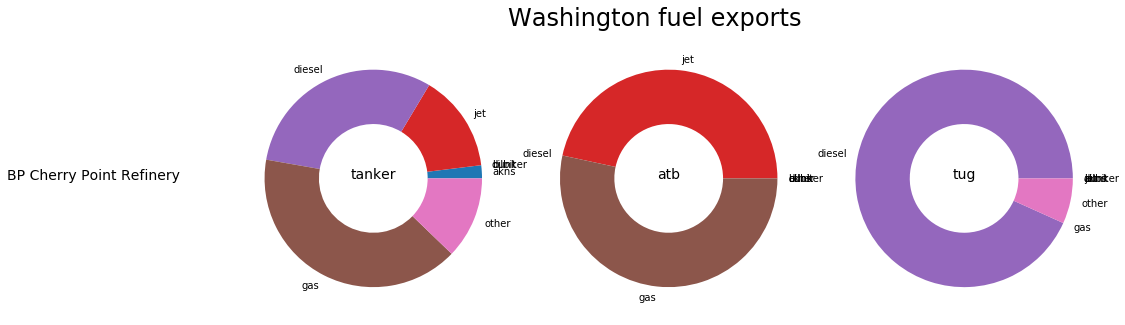

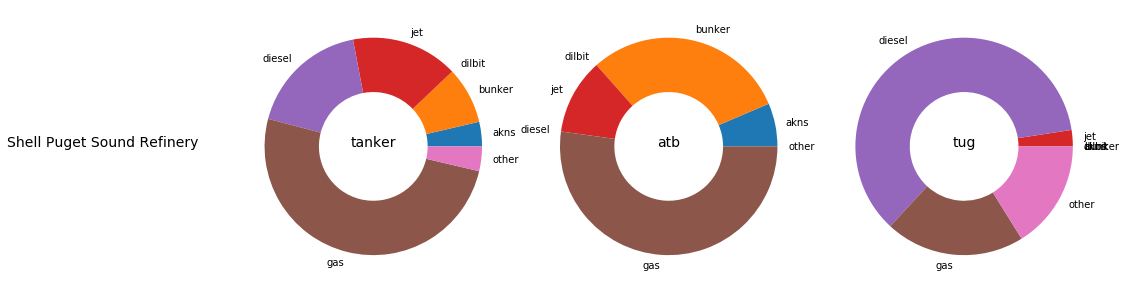

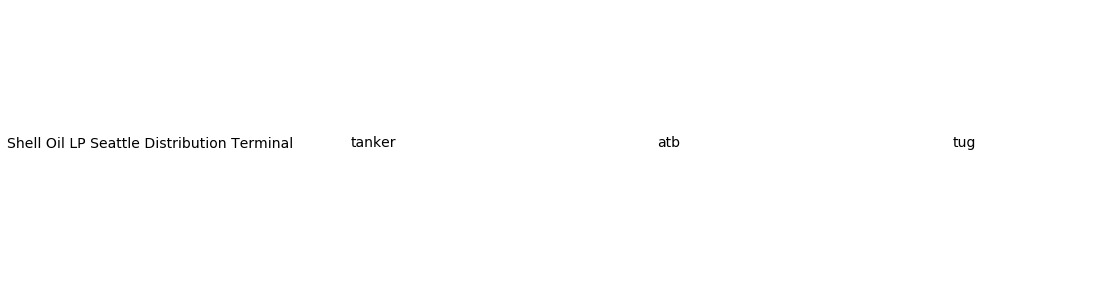

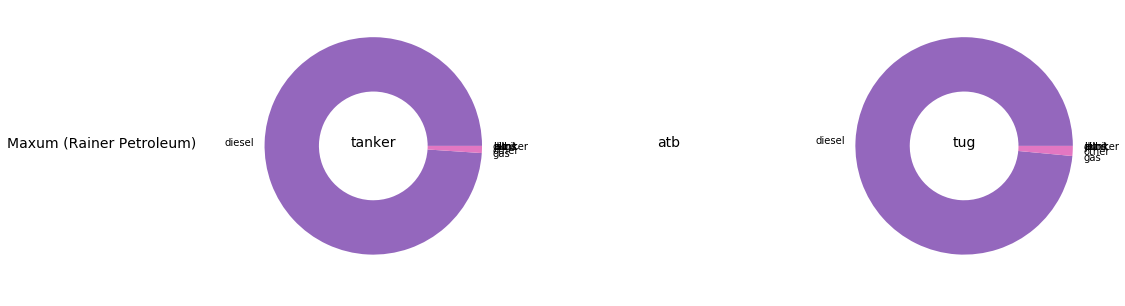

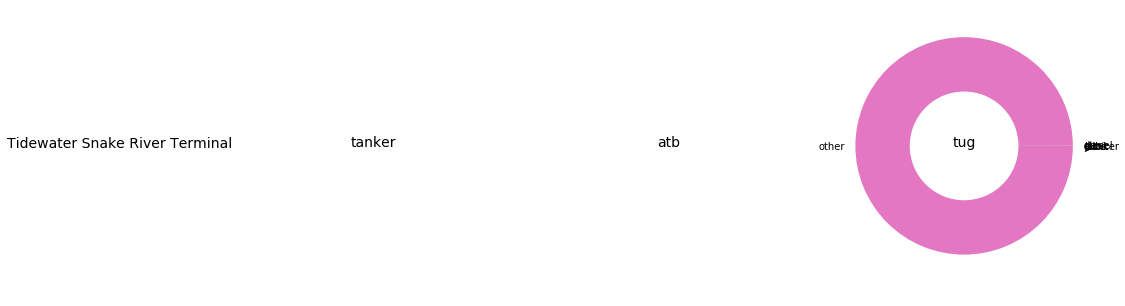

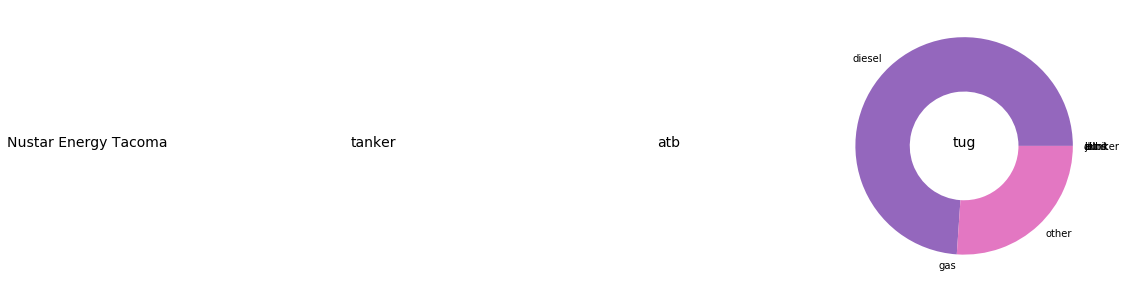

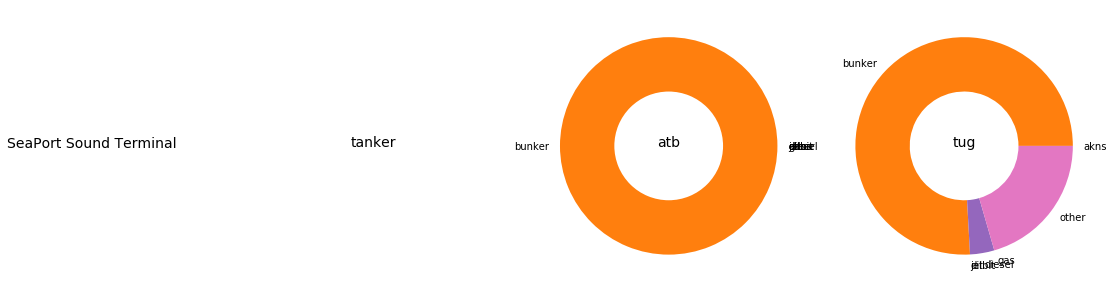

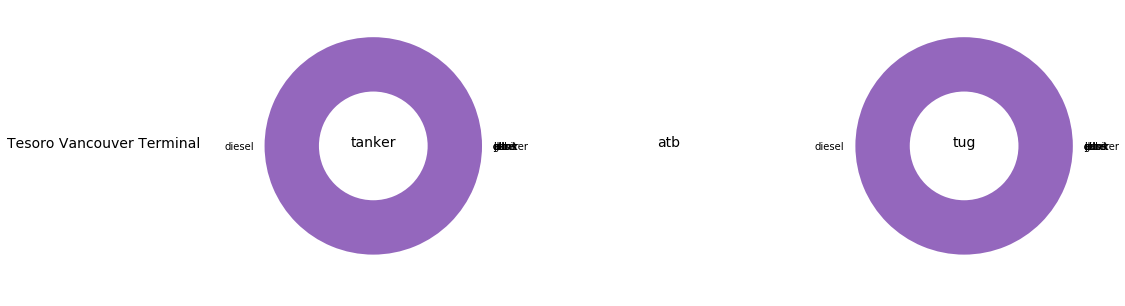

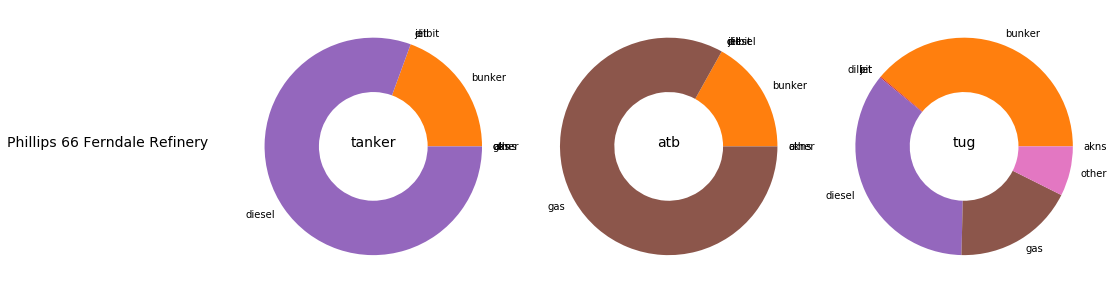

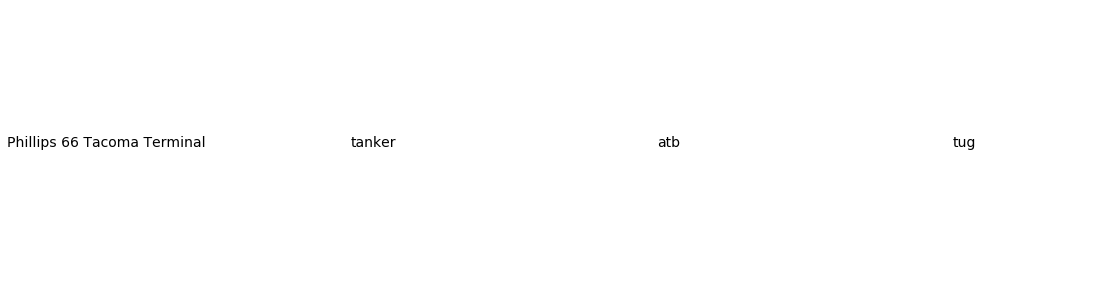

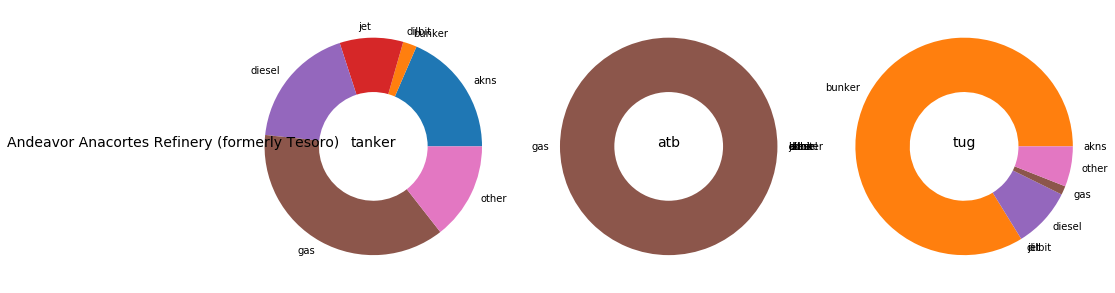

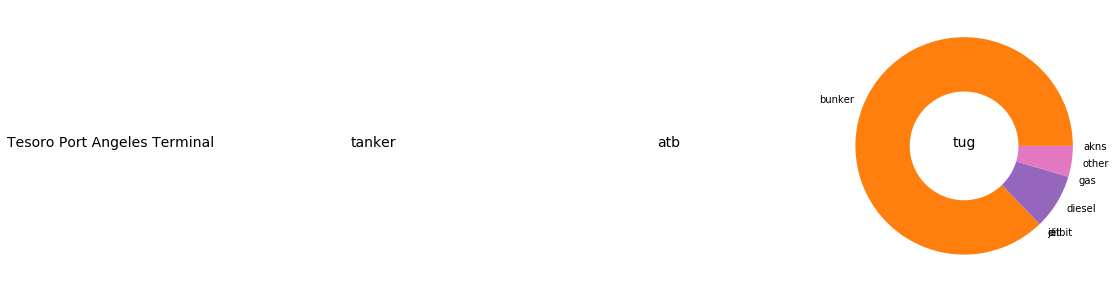

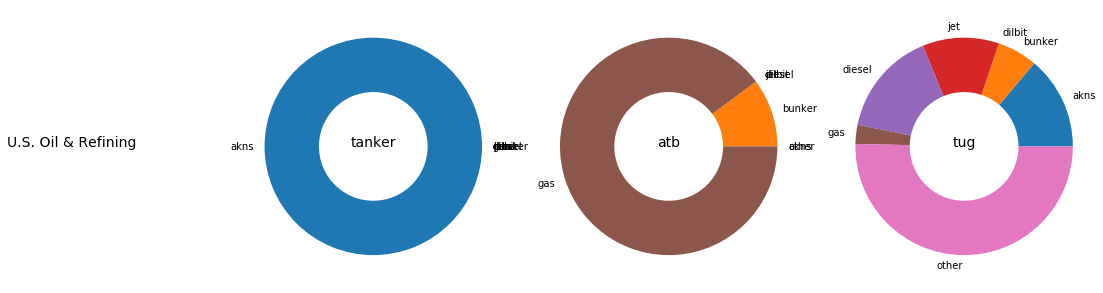

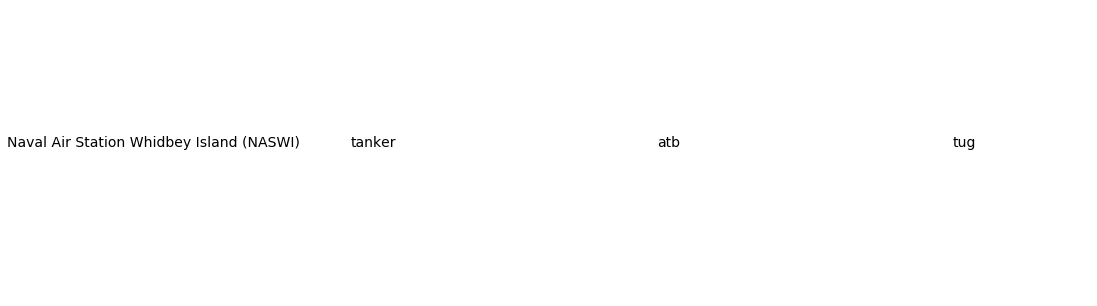

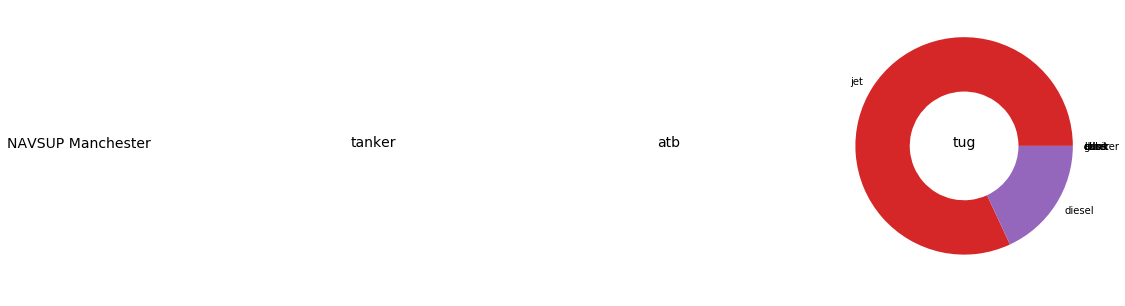

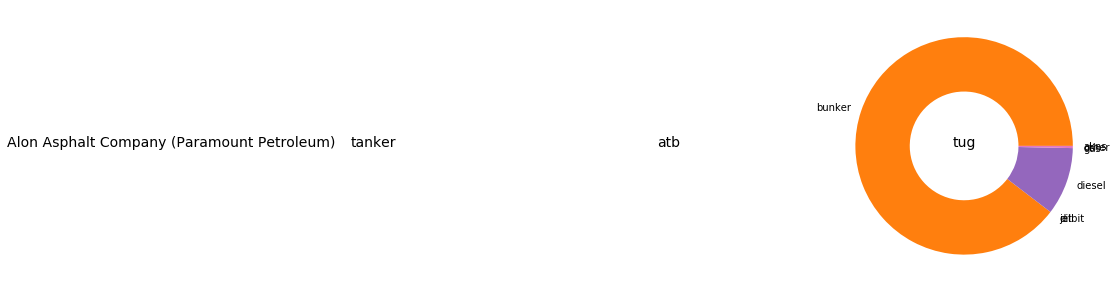

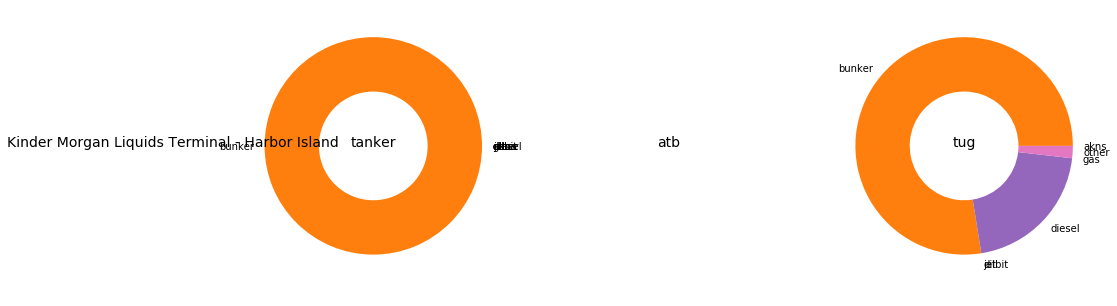

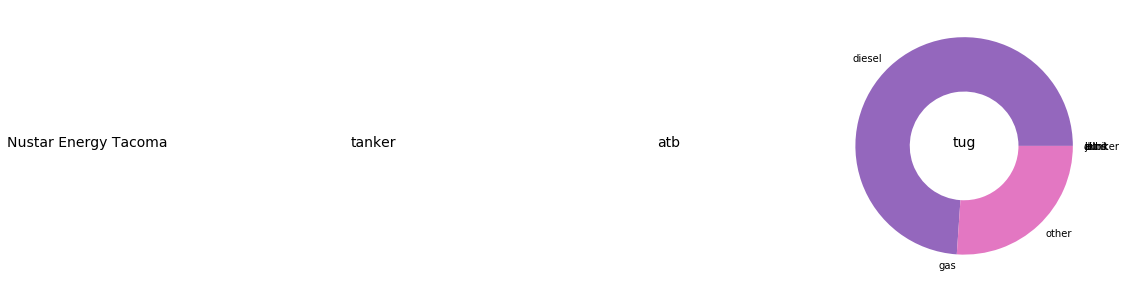

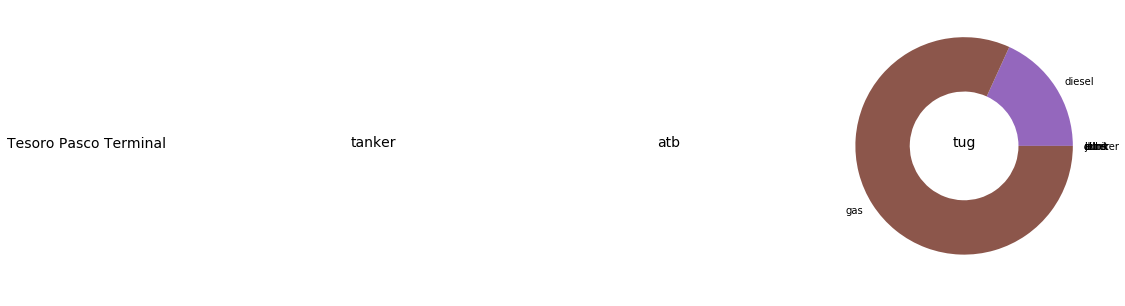

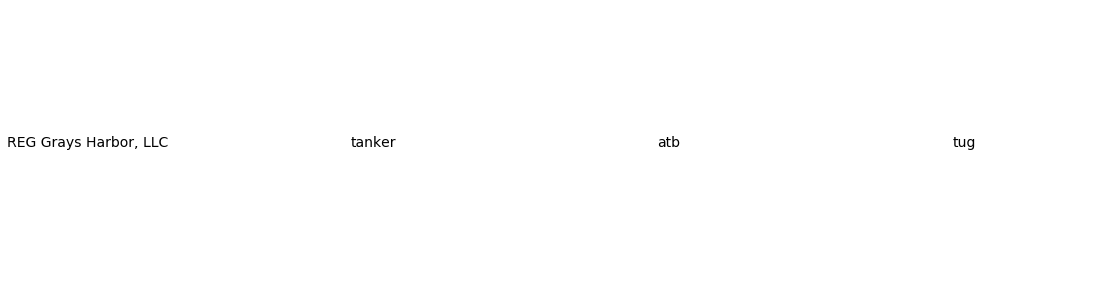

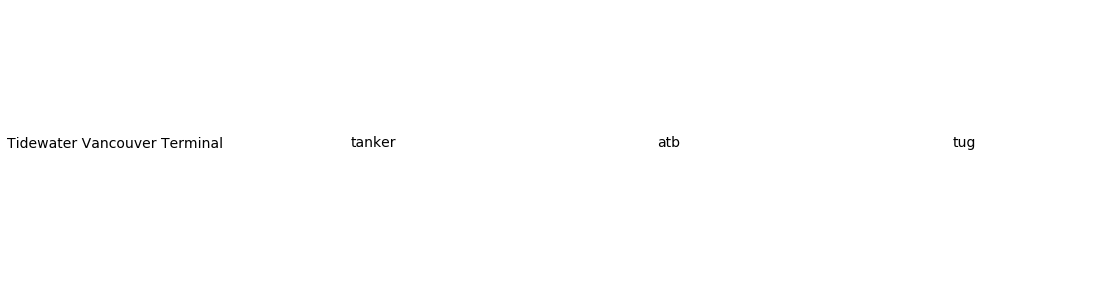

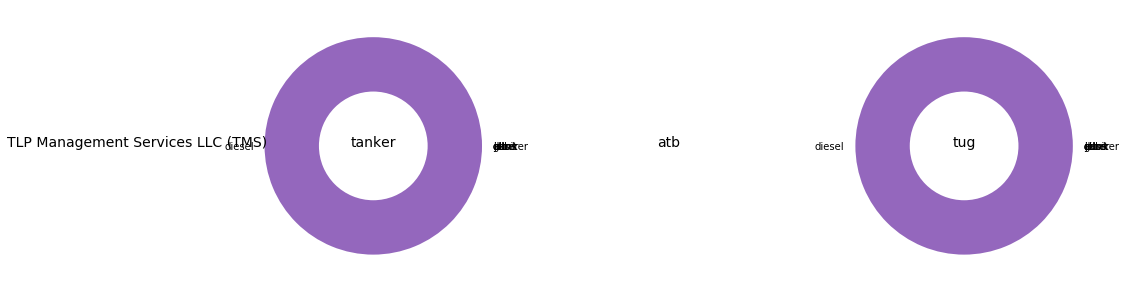

In [14]:
# axes are in a two-dimensional array, indexed by [row, col]
plot_array = np.empty(len(fuel_type))

# Create a circle for the center of the plot
#my_circle=plt.Circle( (0,0), 0.7, color='white')

for i in range(len(origin['names'])):
    fig, axes = plt.subplots(1, len(vessel_types), figsize = (15,5))
    if i == 0:
        fig.suptitle('Washington fuel exports',
                    fontsize = 24)
    facility = origin['names'][i]
    plt.text(-.1, 0.5, 
             f'{facility}', 
             ha='left',
             fontsize=14,
             wrap=True,
             transform=plt.gcf().transFigure)
    for j in range(len(vessel_types)):
        vessel = vessel_types[j]
        # create array of total fuel volume by fuel type for each vessel at each facility
        fuel_index = 0
        for fuel in fuel_type:    
            plot_array[fuel_index]=origin[f'{facility}'][f'{vessel}'][f'{fuel}']['total_gallons']
            fuel_index += 1
        
        axes[j].axis('equal')
        
        if plot_array.sum()>0:
            axes[j].pie(plot_array, wedgeprops=dict(width=0.5), labels = fuel_type)
        else:
            axes[j].axis('off')
        axes[j].text(0,0,f'{vessel}',ha='center',fontsize=14)
       
            
